In [1]:
import sys
sys.path.insert(0, '../..')
from project_utils import *

# Load seed-to-voxel maps
- regressed out motion parameters, framewise displacement, aCompCor CSF PCs for up to 50% variance, cosine basis 

In [20]:
conn_img_fnames = glob.glob(f'{lsa_dir}/connectivity_images/*_LHPC_post*.nii.gz')
conn_img_fnames = sorted(conn_img_fnames)
print(f'image shape: {nib.load(conn_img_fnames[0]).shape}')
sub_info = get_fname_ids(conn_img_fnames, exclude=False)
incl = (sub_info['memory_incl'] == 1) & (sub_info['other_incl'] == 1)
sub_info = sub_info[incl]

# df = sub_info.merge(df, on=['sub_id','dx'])

# for fname in conn_img_fnames:
#     plotting.plot_stat_map(fname)
#     plt.show()

image shape: (97, 115, 97)
n=75


### Create design matrix

In [24]:
fnames = list(sub_info['fname'].values)
cols   = ['dx', 'sex', 'age_years', 'asi_education']
design = pd.DataFrame(columns=cols)

for fname in sub_info['fname']:
    sub_id = int(fname.split('sub-P')[-1].split('_')[0])
    sub_df = beh_df[beh_df['sub_id']==sub_id]      
    design.loc[len(design), cols] = list(sub_df[cols].values[0])
        
design['dx']  = (design['dx']=='HC') * 2 - 1 # want +1, -1 for a simple contrast
design['sex'] = (design['sex']=='female') * 1 # 0, 1
design[['age_years','asi_education']] = design[['age_years','asi_education']] - np.mean(design[['age_years','asi_education']], 0)
design = design.astype(float)
print(design.head(5))

    dx  sex  age_years  asi_education
0  1.0  0.0   9.907545       1.746032
1  1.0  1.0  -2.421921       3.746032
2  1.0  0.0   1.033204      -0.253968
3 -1.0  0.0  13.545439      -0.253968
4  1.0  0.0  -3.303527      -0.253968


# GLMs

63 subjects in a t-test


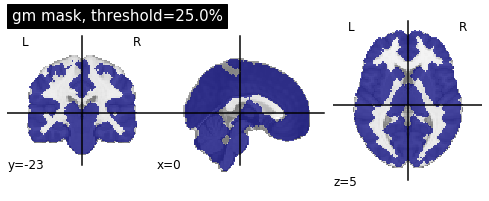


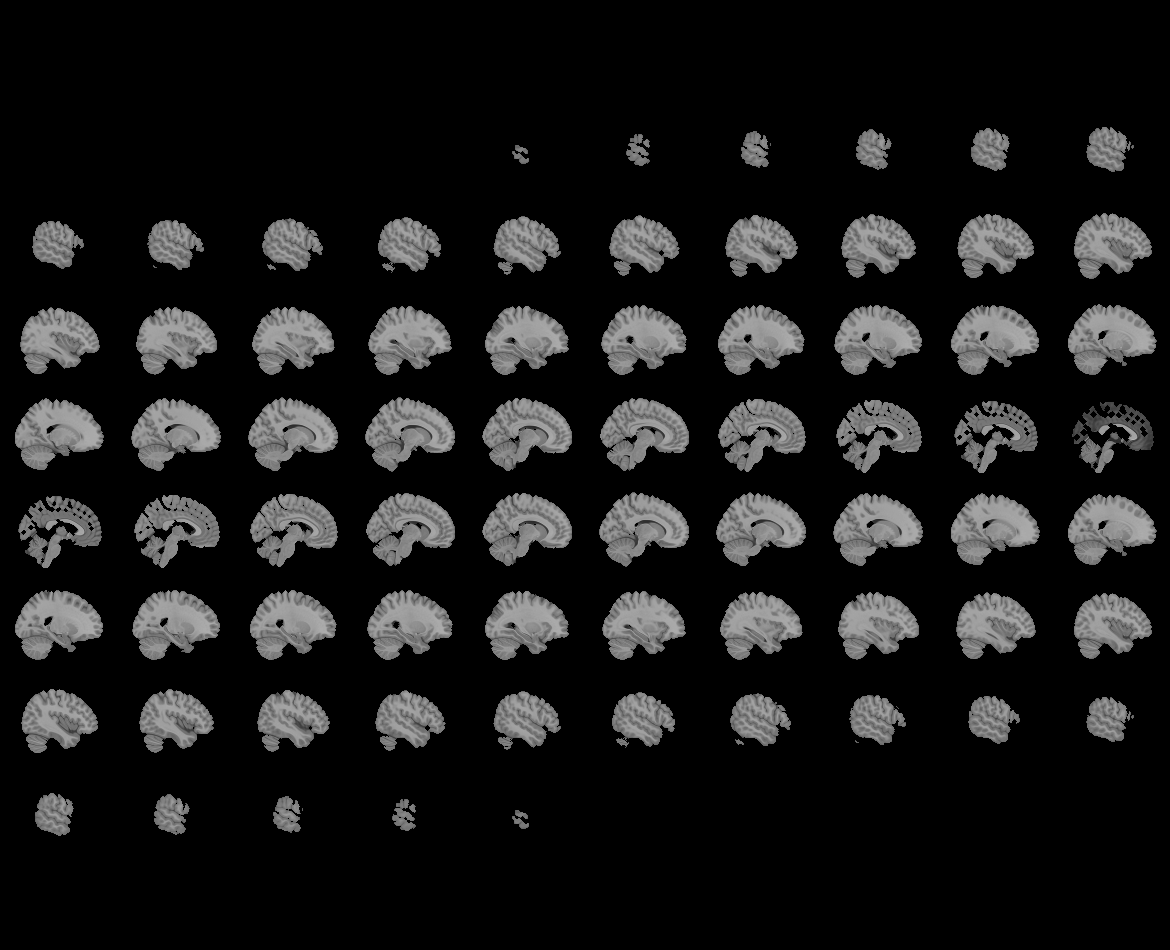
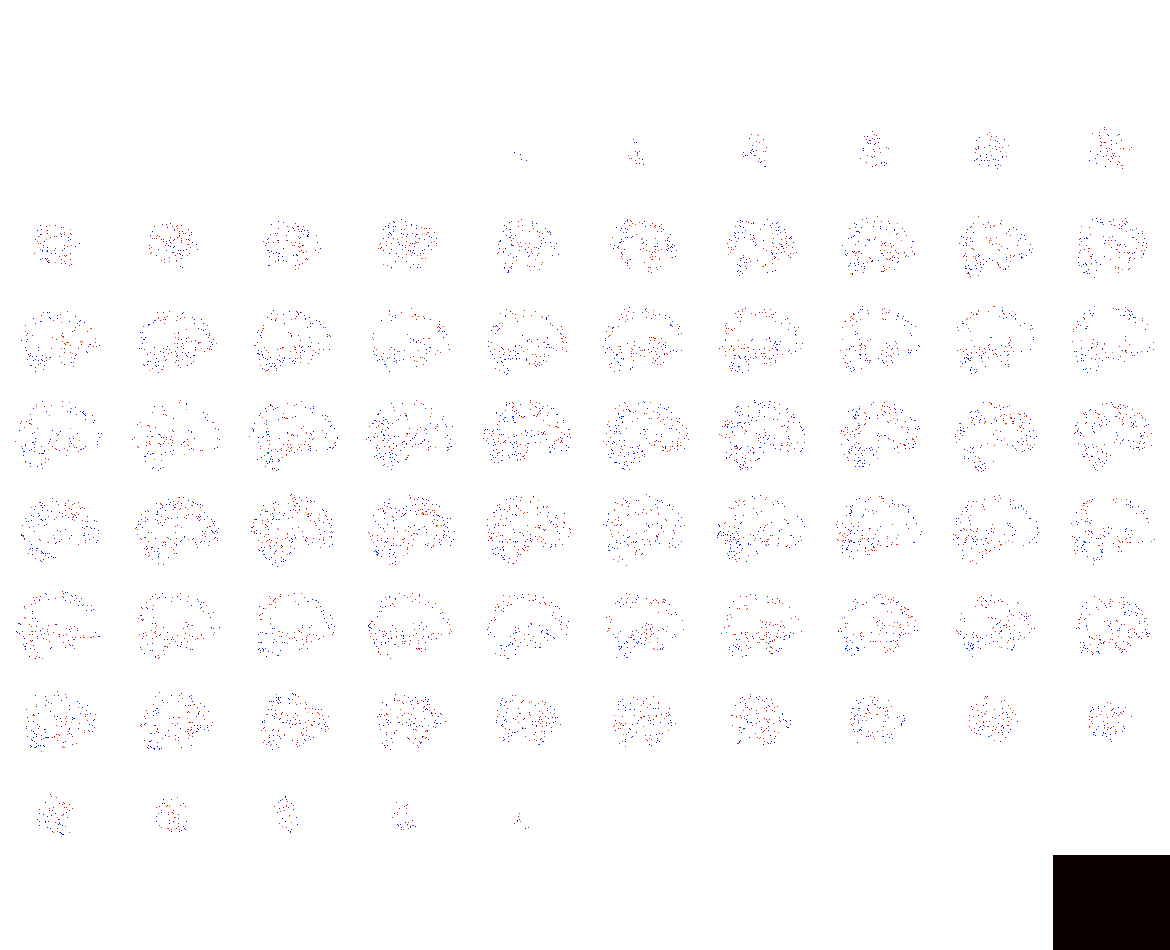

In [25]:
con_img = second_level.compute_ttest(fnames, 
                                     design_matrix=design, plot_design=False,
                                     second_level_contrast='dx')

# mask for mcc
mask_type = 'gm'
threshold = 0.25
mask_img  = nil.masking.compute_multi_brain_mask(fnames, 
                                                 mask_type=mask_type, threshold=threshold, 
                                                 connected=False, # if True, returns only the largest component
                                                 opening=2, # dilations & erosions
                                                 memory=None, verbose=0, n_jobs=1)
nil.plotting.plot_roi(mask_img, title=f'{mask_type} mask, threshold={threshold*100}%')
plt.show()

# mcc
con_img_thr = second_level.threshold_second_level_img(con_img, mask_img=mask_img, 
                                                      alpha=0.05, cluster_extent=0, two_sided=True, 
                                                      height_control='fpr')
nil.plotting.view_img(con_img_thr)


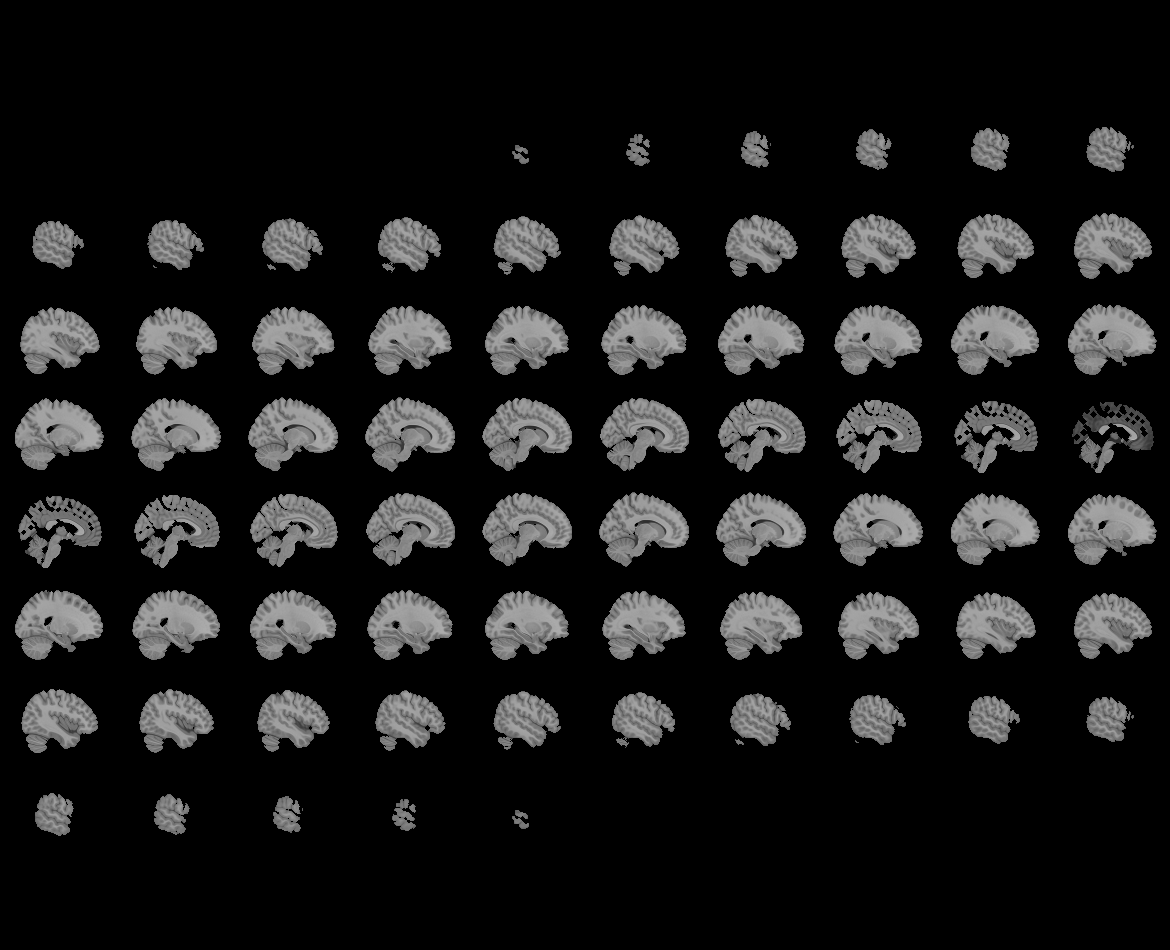
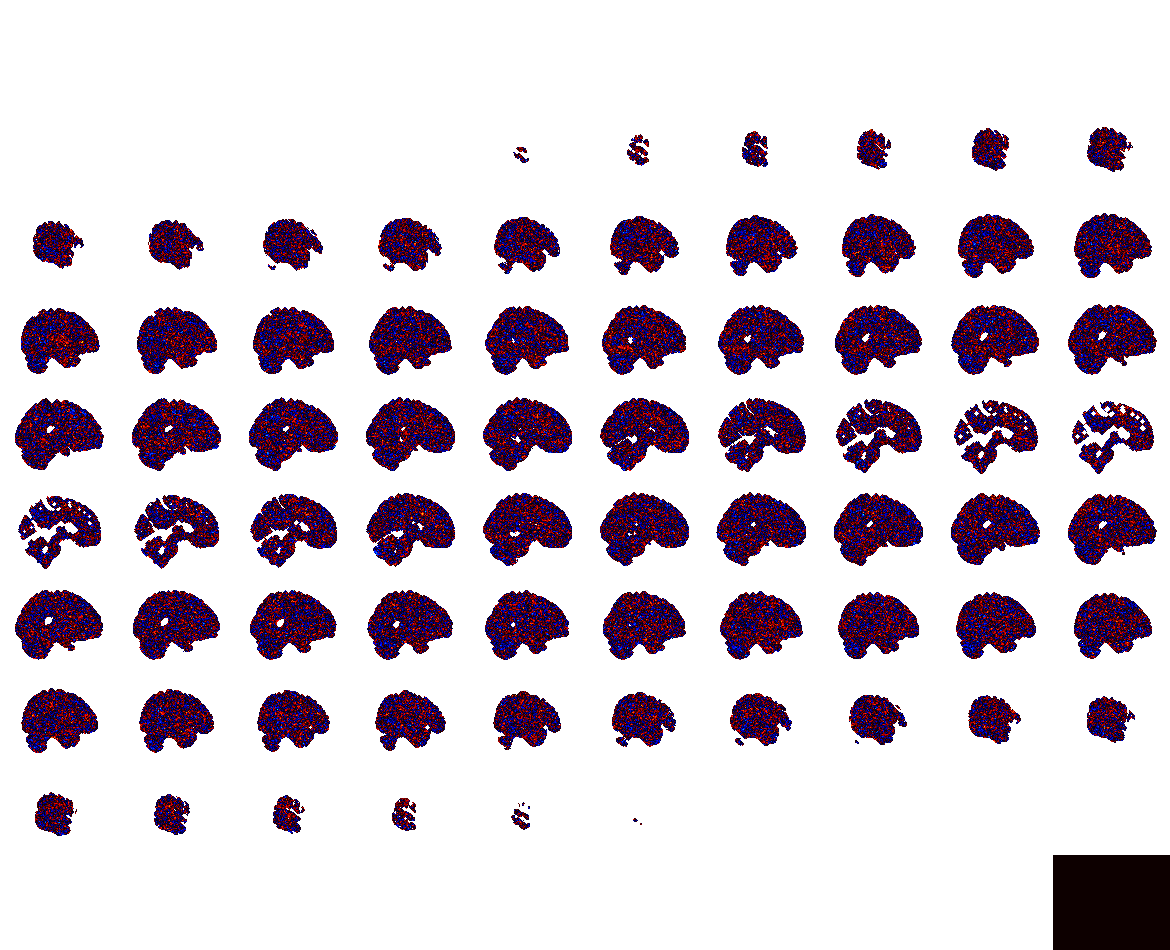

In [26]:
nil.plotting.view_img(con_img)

In [ ]:
## other masks
# lhpc_img = f'{mask_dir}/L-HPC_harvardoxford_maxprob-thr0-1mm.nii'

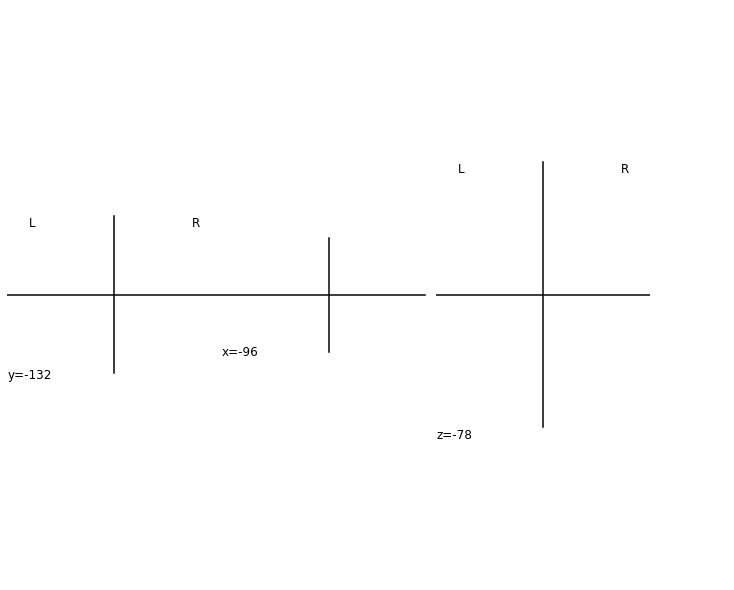

In [24]:
hpc_coords = [(-22,-15,-18)]
ifg_coords = [(51,50,1)]
fig = plt.figure(figsize=(10, 8))
display = plotting.plot_stat_map(con_img_thr, 
                                 #threshold=0,
#                                  cut_coords=hpc_coords[0],
                                 title='', figure=fig)
display.add_markers(marker_coords=hpc_coords, marker_color='black', marker_size=100)
plt.show()

# Classification
https://nilearn.github.io/dev/auto_examples/07_advanced/plot_age_group_prediction_cross_val.html

In [ ]:
# y = LabelEncoder().fit_transform(corr_df_z['dx'])
# X = corr_df_z.iloc[:,2:]

# # prepare the classification pipeline
# pipeline   = Pipeline([('connectivity', ConnectivityMeasure(vectorize=True)),
#                        ('classifier', GridSearchCV(LinearSVC(), {'C': [.1, 1., 10.]}, cv=5))])
# param_grid = [{'classifier': [DummyClassifier(strategy='most_frequent')]},
#               {'connectivity__kind': ['correlation', 'partial correlation', 'tangent']}]

# # grid search over pipeline
# cv = StratifiedShuffleSplit(n_splits=30, random_state=0, test_size=10)
# gs = GridSearchCV(pipeline, param_grid, scoring='accuracy', cv=cv, 
#                   verbose=1, refit=False, n_jobs=8)
# gs.fit(X, y)
# mean_scores = gs.cv_results_['mean_test_score']
# scores_std  = gs.cv_results_['std_test_score']

# plt.figure(figsize=(6, 4))
# positions = [.1, .2, .3, .4]
# plt.barh(positions, mean_scores, align='center', height=.05, xerr=scores_std)
# yticks = ['dummy'] + list(gs.cv_results_['param_connectivity__kind'].data[1:])
# yticks = [t.replace(' ', '\n') for t in yticks]
# plt.yticks(positions, yticks)
# plt.xlabel('Classification accuracy')
# plt.gca().grid(True)
# plt.gca().set_axisbelow(True)
# plt.tight_layout()
# plt.show()

# Network analysis
https://dartbrains.org/content/Connectivity.html

In [ ]:
# binary adjacency matrix
print(f'min={np.round(np.min(diff),3)}, max={np.round(np.max(diff),3)}')
a = nlt.Adjacency(np.abs(diff), matrix_type='similarity') # should I use absolute value?
a_thr = a.threshold(upper=0.1, binarize=True) # where to binarize - depends on the correlation matrix
a_thr.plot()

# network graph
G   = a_thr.to_graph()
pos = nx.kamada_kawai_layout(G) # pos???
node_and_degree = G.degree()

# plot
plt.figure(figsize=(15, 15))
nx.draw_networkx_edges(G, pos, width=3, alpha=.2)
nx.draw_networkx_labels(G, pos, font_size=14, font_color='darkslategray')
nx.draw_networkx_nodes(G, pos, 
                       nodelist=list(dict(node_and_degree).keys()),
                       node_size=[x[1]*100 for x in node_and_degree],
                       node_color=list(dict(node_and_degree).values()),
                       cmap=plt.cm.Reds_r, edgecolors='darkslategray', alpha=1, linewidths=2)

# Correlate w/ self-report variables

In [ ]:
[c for c in df.columns if 'mri' in c]

#### Filter for possible interesting correlations
- focus on regions previously found: e.g., left hippocampus, precuneus/pcc

In [ ]:
sr_corr_df = pd.DataFrame(columns=['n', 'fc_region1', 'fc_region2', 'self-report', 'pvalue', 'beta'])
for sr_col in ['ctq_total_score_2', 
               'sni_num_ppl', 'cssa_total_mri',
               'lsas_social_interaction_fear_subscale', 
               'coc_age_1st_use', 'coc_days_last_use', 'mri_utox___coc']:
        
    X_labels = [sr_col]
                
    if 'coc' not in sr_col: # control for diagnosis if it's not already a cocaine variable
        X_labels.append('C(dx)')
        X_labels.append('C(dx)*' + sr_col)
        mask = np.isfinite(corr_df_z[sr_col])
    else: # ensure its only CUDs
        mask = np.isfinite(corr_df_z[sr_col]) & (corr_df_z['dx'] == 'CD')
    n = np.sum(mask)
                   
    for fc_col in label_cols:
        
        # should also filter for the other region too
        if 'Hippocampus' in fc_col or 'Precun' in fc_col or 'Cingulate' in fc_col: # simplify
            
            # to speed up, filter on bivariate correlation
            _, cor_p = scipy.stats.pearsonr(corr_df_z[fc_col][mask], corr_df_z[sr_col][mask])
            if cor_p < 0.05: 

                # add any interactions
                res_df, ols = run_ols(X_labels, fc_col, corr_df_z[mask], covariates=['age_years', 'sex', 'asi_education'])
                ols_p       = res_df[sr_col + '_pvalue'].values[0]
                ols_b       = res_df[sr_col + '_beta'].values[0]
                if ols_p < 0.005:
                    sr_corr_df.loc[len(sr_corr_df) + 1, :] = [n, fc_col.split('_')[0], fc_col.split('_')[1], sr_col, ols_p, ols_b]
sr_corr_df